In [1]:
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from scipy import sparse
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import torch
import torch.nn as nn

In [2]:
load_dotenv()

True

In [3]:
smish_path = os.getenv("SMISHING_PATH")
smish_csv = pd.read_csv(smish_path)

In [4]:
print(smish_csv.columns)

Index(['LABEL', 'TEXT', 'URL', 'EMAIL', 'PHONE'], dtype='object')


In [5]:
print(smish_csv["LABEL"].unique())

['ham' 'Smishing' 'spam' 'Spam' 'smishing']


In [6]:
smish_csv["LABEL"] = smish_csv["LABEL"].apply(lambda x: x.lower())
print(smish_csv["LABEL"].unique())

['ham' 'smishing' 'spam']


In [7]:
splits = smish_csv["LABEL"].value_counts()

print(splits)

ham         4844
smishing     638
spam         489
Name: LABEL, dtype: int64


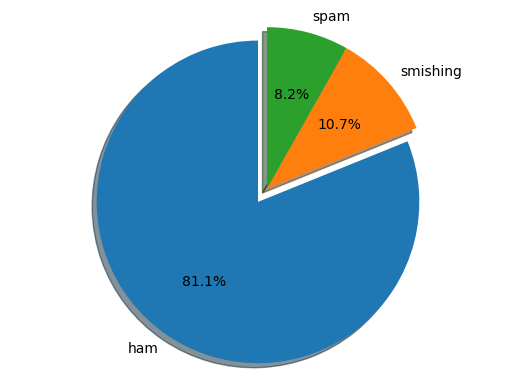

In [8]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(splits.index)
sizes = list(splits)
explode = (0.1, 0, 0,)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:
spam_csv = smish_csv[smish_csv["LABEL"] == "spam"]
ham_csv = smish_csv[smish_csv["LABEL"] == "ham"]
smishing_csv = smish_csv[smish_csv["LABEL"] == "smishing"]

In [10]:
smishing_csv = smishing_csv.sample(frac=1).head(489).reset_index(drop=True)
ham_csv = ham_csv.sample(frac=1).head(489).reset_index(drop=True)

In [11]:
smish_csv = pd.concat([spam_csv, smishing_csv, ham_csv]).sample(frac=1).reset_index(drop=True)

In [12]:
splits = smish_csv["LABEL"].value_counts()

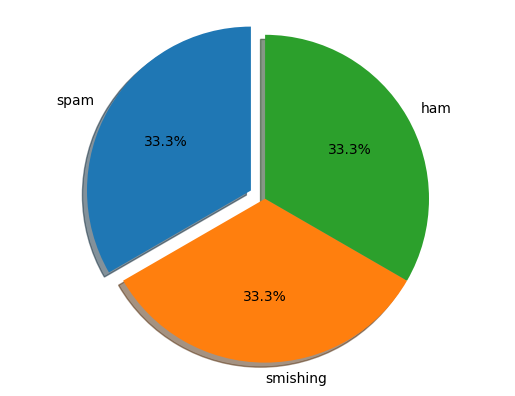

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(splits.index)
sizes = list(splits)
explode = (0.1, 0, 0,)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [14]:
smish_csv

,LABEL,TEXT,URL,EMAIL,PHONE
0,spam,NON-STOP INTERNET and DOWNLOADING with Pocket ...,yes,No,No
1,smishing,You have won a Nokia 7250i. This is what you g...,No,No,yes
2,spam,New TEXTBUDDY Chat 2 guys in ur area 4 just 2...,No,No,yes
3,ham,She's fine. Good to hear from you. How are you...,No,No,No
4,spam,Want a new Video Phone? 750 anytime any networ...,No,No,yes
...,...,...,...,...,...
1462,ham,Today i'm not workin but not free oso... Gee.....,No,No,No
1463,spam,Ur balance is now £600. Next question: Complet...,No,No,yes
1464,spam,For ur chance to win a £250 cash every wk TXT:...,yes,No,No
1465,spam,"I want some cock! My hubby's away, I need a re...",No,No,yes


In [15]:
text = "asdasd12312@#$%^&*()"

print(re.sub('\W+', '', text))

key_dict = {"No": 0, "yes": 1}

other_lamb = lambda x: key_dict[x]

smish_csv["TEXT"] = smish_csv["TEXT"].apply(lambda x: re.sub('\W+', ' ', x.lower()))

smish_csv["URL"] = smish_csv["URL"].apply(other_lamb)
smish_csv["PHONE"] = smish_csv["PHONE"].apply(other_lamb)
smish_csv["EMAIL"] = smish_csv["EMAIL"].apply(other_lamb)

smish_csv


asdasd12312


,LABEL,TEXT,URL,EMAIL,PHONE
0,spam,non stop internet and downloading with pocket ...,1,0,0
1,smishing,you have won a nokia 7250i this is what you ge...,0,0,1
2,spam,new textbuddy chat 2 guys in ur area 4 just 25...,0,0,1
3,ham,she s fine good to hear from you how are you m...,0,0,0
4,spam,want a new video phone 750 anytime any network...,0,0,1
...,...,...,...,...,...
1462,ham,today i m not workin but not free oso gee thgt...,0,0,0
1463,spam,ur balance is now 600 next question complete t...,0,0,1
1464,spam,for ur chance to win a 250 cash every wk txt a...,1,0,0
1465,spam,i want some cock my hubby s away i need a real...,0,0,1


In [16]:
train_df, test_df = train_test_split(smish_csv, test_size=0.2, random_state=42)

In [17]:
len(train_df), len(test_df)

(1173, 294)

In [18]:
def train_models(train_x,
                 train_y,
                 test_x,
                 test_y):
    
    clf_log = LogisticRegression(random_state=0).fit(train_x, train_y)
    clf_svm = svm.SVC(kernel="sigmoid").fit(train_x, train_y)
    clf_bayes = MultinomialNB().fit(train_x, train_y)
        
    ret_dict = {"Logistic_Regression": clf_log.score(test_x, test_y),
                "Support Vector Classifer": clf_svm.score(test_x, test_y),
                "Multinomial Naive Bayes": clf_bayes.score(test_x, test_y)}
    
    return ret_dict
    

In [19]:
tfidf_vec = TfidfVectorizer()
train_tfidf = tfidf_vec.fit_transform(train_df["TEXT"].to_list())

train_flags = train_df.to_numpy()[:, 2:]

train_arr = train_tfidf.toarray()
train_full_arr = np.hstack([train_arr, train_flags.astype(float)])

train_full_arr = sparse.csr_matrix(train_full_arr)


test_tfidf = tfidf_vec.transform(test_df["TEXT"].to_list())

test_flags = test_df.to_numpy()[:, 2:]

test_arr = test_tfidf.toarray()
test_full_arr = np.hstack([test_arr, test_flags.astype(float)])

test_full_arr = sparse.csr_matrix(test_full_arr)

print(test_full_arr)

  (0, 117)	0.23321730253032785
  (0, 349)	0.19239535317345638
  (0, 389)	0.188480394567257
  (0, 493)	0.23999195946333185
  (0, 668)	0.27403925188719935
  (0, 1269)	0.1446842391208129
  (0, 1295)	0.181705737634253
  (0, 1500)	0.17219583196004265
  (0, 1512)	0.2142361770152944
  (0, 1724)	0.18493888372371511
  (0, 1746)	0.1787315315446804
  (0, 1905)	0.10962195291763493
  (0, 2270)	0.2142361770152944
  (0, 2790)	0.2017336292602566
  (0, 2916)	0.10541886246807186
  (0, 3834)	0.5179461699567306
  (0, 3900)	0.06342341328041781
  (0, 3958)	0.2181511356214938
  (0, 3972)	0.1219026627623481
  (0, 4166)	0.15834806074958893
  (0, 4208)	0.1536972812746846
  (0, 4223)	0.18493888372371511
  (0, 4264)	0.13177559180873882
  (0, 4312)	1.0
  (0, 4314)	1.0
  :	:
  (293, 1884)	0.10258509521114031
  (293, 1905)	0.11525995081523036
  (293, 1924)	0.12849921090301522
  (293, 1969)	0.13338918594234622
  (293, 1993)	0.15936901873954998
  (293, 2075)	0.28813344273927727
  (293, 2202)	0.15036273374236547
  (293

In [20]:
train_models(train_full_arr, 
             train_df["LABEL"].to_list(),
             test_full_arr,
             test_df["LABEL"].to_list())

{'Logistic_Regression': 0.8775510204081632,
 'Support Vector Classifer': 0.8537414965986394,
 'Multinomial Naive Bayes': 0.8673469387755102}

In [21]:
# c_vec = CountVectorizer()
# train_cvec = c_vec.fit_transform(train_df["TEXT"].to_list())

In [75]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self, input_params: int):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(input_params, 1000)
        self.activation = torch.nn.ReLU()
        # self.linear2 = torch.nn.Linear(200, 50)
        self.linear3 = torch.nn.Linear(3, 1)
        self.linear4 = torch.nn.Linear(1001, 3)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x_1, x_2):
        x_1 = self.linear1(x_1)
        x_1 = self.activation(x_1)
        # x_1 = self.activation(self.linear2(x_1))
        
        x_2 = self.activation(self.linear3(x_2))
        
        x = torch.cat((x_1, x_2), -1)
        
        x = self.linear4(x)
        x = self.softmax(x)
        return x

In [76]:
x_1 = torch.randn((1, 10000))

x_2 = torch.randn((1, 3))

In [77]:
t_m = TinyModel(10_000)

print(x_1.size())
print
t_m(x_1, x_2)

torch.Size([1, 10000])


tensor([[0.3433, 0.3135, 0.3432]], grad_fn=<SoftmaxBackward0>)

In [78]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomPhishingDataset(Dataset):
    def __init__(self, vectorizer, df):
        self.__vec = vectorizer
        self.__df = df
        
        self.__labels = {"spam": 0,
                         "smishing": 1,
                         "ham": 2}

    def __len__(self):
        return len(self.__df)

    def __getitem__(self, idx):
        
        label = torch.tensor([0, 0, 0])
        row = self.__df.iloc[idx]
        
        flags = row.to_numpy()[2:].astype(float)
        label[self.__labels[row["LABEL"]]] = 1
        
        text = np.squeeze(self.__vec.transform([row["TEXT"]]).toarray(), axis=0)
        return label, torch.tensor(flags), torch.tensor(text)

In [79]:
train_dataset = CustomPhishingDataset(tfidf_vec, train_df)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomPhishingDataset(tfidf_vec, test_df)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [80]:
for i in train_dataloader:
    
    shape = i[-1].size()[-1]
    break

In [81]:
my_model = TinyModel(shape)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(my_model.parameters(), lr=0.001)

In [82]:
def get_test():
    
    with torch.no_grad():
        my_model.eval()
        correct = 0
        
        for i in test_dataloader:
            # get the inputs; data is a list of [inputs, labels]
            labels, flag, text = i

        
            flag = flag.to(torch.float32)
            text = text.to(torch.float32)
            labels = labels.to(torch.float32)


            # forward + backward + optimize
            output = my_model(text, flag)
            labels = labels
            
            if torch.argmax(output) == torch.argmax(labels):
                correct += 1


        print(correct / len(test_dataloader))
        
        

In [83]:
for epoch in range(20):  # loop over the dataset multiple times
    
    my_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        labels, flag, text = data

        
        flag = flag.to(torch.float32)
        text = text.to(torch.float32)
        labels = labels.to(torch.float32)

        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        output = my_model(text, flag)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()

        # print statistics
        running_loss += loss.item()
    print(running_loss)
    get_test()

print('Finished Training')

20.36780345439911
0.8673469387755102
16.897332847118378
0.8843537414965986
12.978039264678955
0.8877551020408163
11.68016129732132
0.8877551020408163
11.322554290294647
0.891156462585034
11.133921146392822
0.8877551020408163
11.093014240264893
0.8877551020408163
11.00696337223053
0.8945578231292517
10.980870425701141
0.8877551020408163
10.961597561836243
0.8945578231292517
10.999854922294617
0.891156462585034
10.926240146160126
0.8843537414965986
10.963519215583801
0.8877551020408163
10.903410851955414
0.8809523809523809
10.897393941879272
0.8809523809523809
10.895951628684998
0.8809523809523809
10.884078204631805
0.8809523809523809
10.865230321884155
0.8843537414965986
10.852858424186707
0.8843537414965986
10.859665274620056
0.8809523809523809
Finished Training


In [89]:
bar_dict = {'Logistic_Regression': 0.8775510204081632,
            'Support Vector Classifer': 0.8537414965986394,
            'Multinomial Naive Bayes': 0.8673469387755102,
            'Multi Layer Perceptron': 0.8945578231292517}

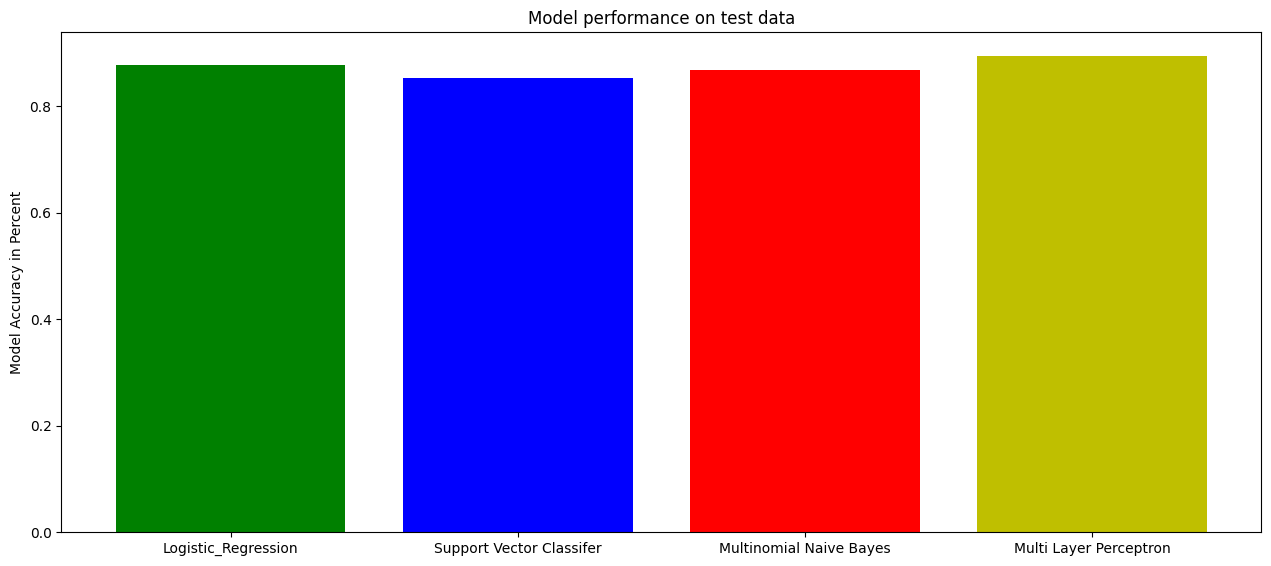

In [105]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Model Accuracy in Percent')
ax.set_title('Model performance on test data')

langs = list(bar_dict.keys())
students = list(bar_dict.values())
ax.bar(langs[0], students[0], color="g")
ax.bar(langs[1], students[1], color="b")
ax.bar(langs[2], students[2], color="r")
ax.bar(langs[3], students[3], color="y")
plt.show()